Non-negative Basis Pursuit DeNoising (ADMM)
===========================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve
the non-negative sparse coding problem problem

  $$\mathrm{argmin}_{\mathbf{x}} \; \| \mathbf{y} - D \mathbf{x} \|_2^2
  + \lambda \| \mathbf{x} \|_1 + I(\mathbf{x} \geq 0)\;,$$

where $D$ the dictionary, $\mathbf{y}$ the signal to be represented,
$\mathbf{x}$ is the sparse representation, and $I(\mathbf{x} \geq 0)$
is the non-negative indicator.

In [1]:
import numpy as np

import jax

from scico import functional, linop, loss, plot
from scico.admm import ADMM, LinearSubproblemSolver
plot.config_notebook_plotting()

Create random dictionary, reference random sparse representation, and
test signal consisting of the synthesis of the reference sparse
representation.

In [2]:
m = 32  # signal size
n = 128  # dictionary size
s = 10  # sparsity level

np.random.seed(1)
D = np.random.randn(m, n)
D = D / np.linalg.norm(D, axis=0, keepdims=True)  # normalize dictionary

xt = np.zeros(n)  # true signal
idx = np.random.randint(low=0, high=n, size=s)  # support of xt
xt[idx] = np.random.rand(s)
y = D @ xt + 5e-2 * np.random.randn(m)  # synthetic signal

xt = jax.device_put(xt)  # convert to jax array, push to GPU
y = jax.device_put(y)  # convert to jax array, push to GPU

Set up the forward operator and ADMM solver object.

In [3]:
lmbda = 1e-1
A = linop.MatrixOperator(D)
f = loss.SquaredL2Loss(y=y, A=A)
g_list = [lmbda * functional.L1Norm(), functional.NonNegativeIndicator()]
C_list = [linop.Identity((n)), linop.Identity((n))]
rho_list = [1.0, 1.0]
maxiter = 100  # number of ADMM iterations

solver = ADMM(
    f=f,
    g_list=g_list,
    C_list=C_list,
    rho_list=rho_list,
    x0=A.adj(y),
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(),
    verbose=True,
)

Run the solver.

In [4]:
x = solver.solve()

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  1.87e+00  2.810e+00    1.435e+00  4.750e+00
   1  3.28e+00  6.810e-01    4.430e-01  8.297e-01
   2  3.33e+00  6.931e-01    3.791e-01  2.579e-01
   3  3.38e+00  6.060e-01    2.025e-01  1.891e-01
   4  3.41e+00  5.527e-01    1.014e-01  1.657e-01


   5  3.44e+00  5.219e-01    7.435e-02  1.383e-01
   6  3.47e+00  5.079e-01    7.708e-02  1.088e-01
   7  3.50e+00  4.989e-01    5.200e-02  9.590e-02
   8  3.54e+00  4.928e-01    4.370e-02  8.704e-02
   9  3.56e+00  4.904e-01    5.080e-02  7.129e-02
  10  3.59e+00  4.879e-01    3.589e-02  6.160e-02
  11  3.62e+00  4.858e-01    3.085e-02  5.368e-02


  12  3.65e+00  4.847e-01    3.254e-02  4.529e-02
  13  3.67e+00  4.829e-01    2.271e-02  3.870e-02
  14  3.71e+00  4.811e-01    1.596e-02  3.524e-02
  15  3.75e+00  4.797e-01    1.319e-02  3.197e-02
  16  3.78e+00  4.785e-01    1.167e-02  2.921e-02
  17  3.82e+00  4.775e-01    1.091e-02  2.673e-02


  18  3.85e+00  4.765e-01    1.011e-02  2.467e-02
  19  3.89e+00  4.757e-01    9.884e-03  2.269e-02
  20  3.92e+00  4.753e-01    1.018e-02  2.036e-02
  21  3.95e+00  4.750e-01    9.116e-03  1.848e-02
  22  3.97e+00  4.749e-01    8.490e-03  1.640e-02
  23  4.00e+00  4.749e-01    8.105e-03  1.462e-02
  24  4.04e+00  4.748e-01    6.656e-03  1.307e-02


  25  4.08e+00  4.746e-01    5.801e-03  1.176e-02
  26  4.10e+00  4.744e-01    5.057e-03  1.065e-02
  27  4.13e+00  4.742e-01    4.407e-03  9.717e-03
  28  4.16e+00  4.740e-01    3.852e-03  8.930e-03
  29  4.19e+00  4.739e-01    3.385e-03  8.260e-03
  30  4.22e+00  4.737e-01    2.998e-03  7.681e-03
  31  4.24e+00  4.736e-01    2.681e-03  7.170e-03
  32  4.27e+00  4.735e-01    2.423e-03  6.714e-03


  33  4.30e+00  4.734e-01    2.210e-03  6.299e-03
  34  4.32e+00  4.733e-01    2.034e-03  5.919e-03
  35  4.35e+00  4.733e-01    1.883e-03  5.567e-03
  36  4.38e+00  4.732e-01    1.753e-03  5.239e-03
  37  4.41e+00  4.732e-01    1.637e-03  4.933e-03
  38  4.45e+00  4.731e-01    1.533e-03  4.646e-03
  39  4.48e+00  4.731e-01    1.438e-03  4.377e-03


  40  4.51e+00  4.732e-01    1.711e-03  3.709e-03
  41  4.53e+00  4.732e-01    1.777e-03  3.219e-03
  42  4.56e+00  4.732e-01    1.506e-03  2.784e-03
  43  4.61e+00  4.732e-01    1.417e-03  2.403e-03
  44  4.66e+00  4.732e-01    1.297e-03  2.078e-03
  45  4.69e+00  4.732e-01    1.166e-03  1.802e-03


  46  4.72e+00  4.731e-01    1.036e-03  1.566e-03
  47  4.75e+00  4.731e-01    9.219e-04  1.341e-03
  48  4.78e+00  4.731e-01    8.267e-04  1.142e-03
  49  4.81e+00  4.731e-01    7.104e-04  9.697e-04
  50  4.83e+00  4.731e-01    6.210e-04  8.221e-04
  51  4.86e+00  4.731e-01    5.394e-04  6.971e-04
  52  4.89e+00  4.730e-01    4.663e-04  5.905e-04
  53  4.91e+00  4.730e-01    4.013e-04  4.993e-04


  54  4.93e+00  4.730e-01    3.439e-04  4.219e-04
  55  4.96e+00  4.730e-01    2.936e-04  3.562e-04
  56  4.98e+00  4.730e-01    2.498e-04  3.007e-04
  57  5.01e+00  4.730e-01    2.099e-04  2.506e-04
  58  5.03e+00  4.730e-01    1.780e-04  2.145e-04
  59  5.06e+00  4.730e-01    1.506e-04  1.818e-04
  60  5.08e+00  4.730e-01    1.274e-04  1.548e-04
  61  5.11e+00  4.730e-01    1.080e-04  1.320e-04


  62  5.13e+00  4.730e-01    9.141e-05  1.132e-04
  63  5.16e+00  4.730e-01    7.721e-05  9.759e-05
  64  5.18e+00  4.730e-01    6.170e-05  7.761e-05
  65  5.21e+00  4.730e-01    5.081e-05  7.133e-05
  66  5.23e+00  4.730e-01    4.402e-05  6.308e-05
  67  5.25e+00  4.730e-01    3.880e-05  5.695e-05
  68  5.27e+00  4.730e-01    3.305e-05  5.026e-05
  69  5.28e+00  4.730e-01    2.900e-05  4.579e-05
  70  5.30e+00  4.730e-01    1.966e-05  2.374e-05
  71  5.32e+00  4.730e-01    2.221e-05  3.919e-05


  72  5.34e+00  4.730e-01    1.348e-05  2.179e-05
  73  5.36e+00  4.730e-01    1.348e-05  0.000e+00
  74  5.38e+00  4.730e-01    1.348e-05  0.000e+00
  75  5.40e+00  4.730e-01    1.044e-05  2.067e-05
  76  5.41e+00  4.730e-01    1.044e-05  0.000e+00
  77  5.43e+00  4.730e-01    7.163e-06  1.302e-05
  78  5.45e+00  4.730e-01    7.163e-06  0.000e+00
  79  5.47e+00  4.730e-01    8.850e-06  1.205e-05
  80  5.49e+00  4.730e-01    8.850e-06  0.000e+00
  81  5.51e+00  4.730e-01    3.871e-06  9.385e-06


  82  5.54e+00  4.730e-01    3.871e-06  0.000e+00
  83  5.56e+00  4.730e-01    3.871e-06  0.000e+00
  84  5.59e+00  4.730e-01    3.871e-06  0.000e+00
  85  5.61e+00  4.730e-01    3.871e-06  0.000e+00
  86  5.64e+00  4.730e-01    6.685e-06  9.553e-06
  87  5.66e+00  4.730e-01    6.685e-06  0.000e+00
  88  5.68e+00  4.730e-01    6.685e-06  0.000e+00
  89  5.71e+00  4.730e-01    3.372e-06  7.933e-06
  90  5.73e+00  4.730e-01    3.372e-06  0.000e+00


  91  5.76e+00  4.730e-01    3.372e-06  0.000e+00
  92  5.78e+00  4.730e-01    3.372e-06  0.000e+00
  93  5.81e+00  4.730e-01    3.372e-06  0.000e+00
  94  5.83e+00  4.730e-01    3.372e-06  0.000e+00
  95  5.85e+00  4.730e-01    6.564e-06  8.057e-06
  96  5.88e+00  4.730e-01    6.564e-06  0.000e+00
  97  5.90e+00  4.730e-01    6.564e-06  0.000e+00
  98  5.92e+00  4.730e-01    3.105e-06  7.714e-06
  99  5.94e+00  4.730e-01    3.105e-06  0.000e+00


Plot the recovered coefficients and signal.

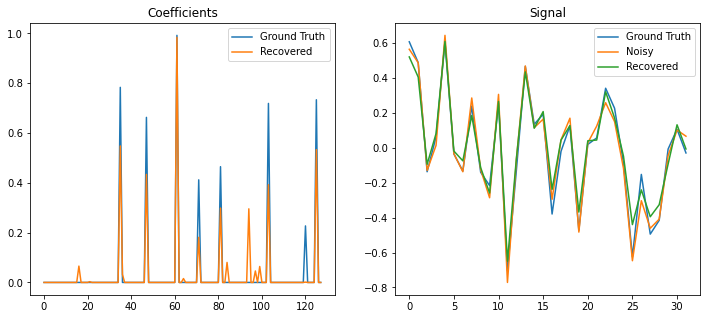

In [5]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    np.vstack((xt, solver.x)).T,
    title="Coefficients",
    lgnd=("Ground Truth", "Recovered"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack((D @ xt, y, D @ solver.x)).T,
    title="Signal",
    lgnd=("Ground Truth", "Noisy", "Recovered"),
    fig=fig,
    ax=ax[1],
)
fig.show()